
**Introduction**

Histopathological cancer detection using CNN, with learning rate reduced on plateau, data augmentation. 


In [2]:
import sys
sys.path.append('/opt/conda/lib/python3.7/site-packages')
sys.path
import pandas as pd
import numpy as np
import seaborn as sns
import cv2

from numpy.random import seed
seed(101)
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback

from tensorflow.keras.optimizers import Adam, SGD

import os

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline






In [3]:
print(tf.__version__)

2.1.0


In [4]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

### Labels as per csv file

0 = no tumor tissue<br>
1 =   has tumor tissue. <br>


### How many images are in each folder?

In [5]:
print(len(os.listdir('Project/train')))

220025


### Create a Dataframe containing all images

In [6]:
df_data = pd.read_csv('Project/train_labels.csv')
print(df_data.shape)

(220025, 2)


### Check the class distribution

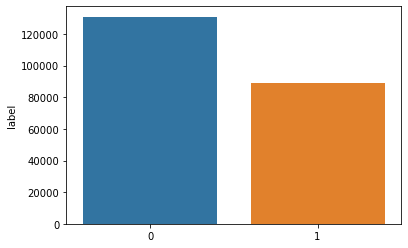

In [7]:
df_data['label'].value_counts()
sns.barplot([0,1], df_data['label'].value_counts())

### Display a random sample of train images  by class

In [8]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16) 
            ax[i, j].axis('off')
    #plt.axis('off')
    plt.tight_layout()
    plt.show()
    

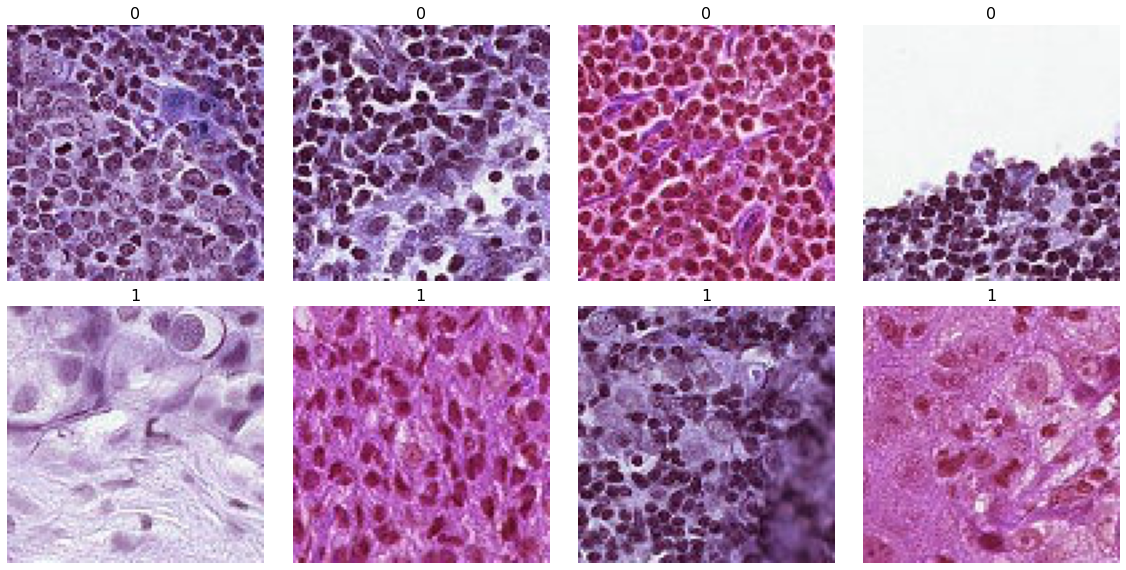

In [9]:
IMAGE_PATH = 'Project/train/' 

draw_category_images('label',4, df_data, IMAGE_PATH)

### Create the Train, Validation and Test Sets

In [10]:
df_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [11]:
# train_test_split
y = df_data['label']

df_train, df_val1 = train_test_split(df_data, test_size=0.30, random_state=42, stratify=y)

y1 = df_val1['label']
df_val, df_test = train_test_split(df_val1, test_size=0.33, random_state=42, stratify=y1)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(154017, 2)
(44225, 2)
(21783, 2)


In [12]:
df_train['label'].value_counts()

0    91635
1    62382
Name: label, dtype: int64

In [13]:
df_val['label'].value_counts()

0    26313
1    17912
Name: label, dtype: int64

In [14]:
df_test['label'].value_counts()

0    12960
1     8823
Name: label, dtype: int64

### Create a Directory Structure

In [25]:
#shutil.rmtree('base_dir')
# Create a new directory
base_dir = 'base_dir_702010'
os.mkdir(base_dir)


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# test_dir
test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

# create new folders inside test_dir
no_tumor_tissue = os.path.join(test_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(test_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

In [15]:
# check that the folders have been created
print(os.listdir('base_dir_702010/train_dir'))
print(os.listdir('base_dir_702010/train_dir'))
print(os.listdir('base_dir_702010/train_dir'))

['a_no_tumor_tissue', 'b_has_tumor_tissue']
['a_no_tumor_tissue', 'b_has_tumor_tissue']
['a_no_tumor_tissue', 'b_has_tumor_tissue']


### Transfer the images into the folders

In [16]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [17]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])
test_list = list(df_test['id'])

In [44]:
# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('Project/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


In [45]:
# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('Project/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    

In [46]:
# Transfer the test images

for image in test_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('Project/train', fname)
    # destination path to image
    dst = os.path.join(test_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    

In [18]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir_702010/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir_702010/train_dir/b_has_tumor_tissue')))

91635
62382


In [19]:
print(len(os.listdir('base_dir_702010/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir_702010/val_dir/b_has_tumor_tissue')))

26313
17912


In [20]:
print(len(os.listdir('base_dir_702010/test_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir_702010/test_dir/b_has_tumor_tissue')))

12960
8823


### Set Up the Generators

In [21]:
train_path = 'base_dir_702010/train_dir'
valid_path = 'base_dir_702010/val_dir'
test_path = 'base_dir_702010/test_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
num_test_samples = len(df_test)
train_batch_size = 20
val_batch_size = 20


train_steps = np.ceil(num_train_samples  / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [22]:
def add_noise_rotate(img_array):
    noise = np.random.randint(-5,6, img_array.shape)
    noise = noise 
    img = img_array + noise
    np.putmask(img, img < 0, 0)
    np.putmask(img, img > 255, 255)
    rot_angle = np.random.randint(0,4)
    img = np.rot90(img, rot_angle)
    return img

In [23]:
datagen = ImageDataGenerator(rescale=1.0/255, vertical_flip=True, horizontal_flip=True, 
                             preprocessing_function=add_noise_rotate)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical', follow_links=True)

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical', follow_links=True)

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False, follow_links=True)

Found 154017 images belonging to 2 classes.
Found 44225 images belonging to 2 classes.
Found 21783 images belonging to 2 classes.


Text(0.5, 1.0, 'Augmented')

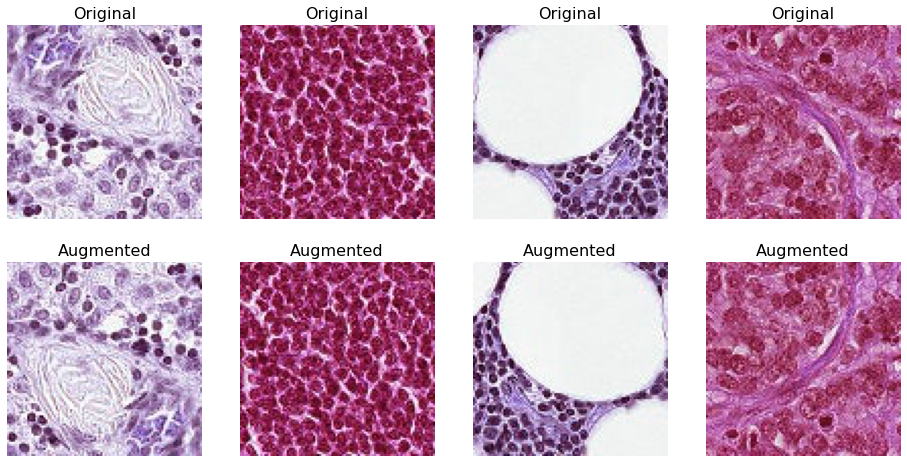

In [24]:
f, ax = plt.subplots(nrows=2,ncols=4, figsize=(16,8))
file = IMAGE_PATH + train_list[np.random.randint(91635)] + '.tif'
im=cv2.imread(file)
[ax[i,j].axis('off') for i in range(2) for j in range(4)]
ax[0,0].imshow(im, resample=True, cmap='gray')
ax[0, 0].set_title('Original', fontsize=16) 
ax[1,0].imshow(datagen.random_transform(im), resample=True, cmap='gray')
ax[1, 0].set_title('Augmented', fontsize=16)

file = IMAGE_PATH + train_list[np.random.randint(91635)] + '.tif'
im=cv2.imread(file)
ax[0,1].imshow(im, resample=True, cmap='gray')
ax[0, 1].set_title('Original', fontsize=16)
ax[1,1].imshow(datagen.random_transform(im), resample=True, cmap='gray')
ax[1, 1].set_title('Augmented', fontsize=16)

file = IMAGE_PATH + train_list[np.random.randint(91635)] + '.tif'
im=cv2.imread(file)
ax[0,2].imshow(im, resample=True, cmap='gray')
ax[0, 2].set_title('Original', fontsize=16)
ax[1,2].imshow(datagen.random_transform(im), resample=True, cmap='gray')
ax[1,2].set_title('Augmented', fontsize=16)

file = IMAGE_PATH + train_list[np.random.randint(91635)] + '.tif'
im=cv2.imread(file)
ax[0,3].imshow(im, resample=True, cmap='gray')
ax[0, 3].set_title('Original', fontsize=16)
ax[1,3].imshow(datagen.random_transform(im), resample=True, cmap='gray')
ax[1, 3].set_title('Augmented', fontsize=16)



### Create the Model Architecture¶

In [ ]:
# source: https://www.avanwyk.com/tensorflow-2-super-convergence-with-the-1cycle-policy/

# One Cycle Policy Class Definition

class CosineAnnealer:
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

In [35]:
#Logistic Regression Model

model = Sequential()
model.add(Flatten(input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0, l2=0.01)))

print(model.summary())

model.compile('SGD', loss='binary_crossentropy', 
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 27648)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 55298     
Total params: 55,298
Trainable params: 55,298
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
# source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

#CNN Model

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_conv))
model.add(Dense(2, activation = "softmax"))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 64)        3

### Train the Model

In [27]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [28]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}


In [40]:
filepath = "cnn_plateau.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

#To be used for varying LR using One Cycle Policy (lr_schedule should replace 
#reduce_lr in callbacks_list)
#steps = num_train_samples * 30
#lr_schedule = OneCycleScheduler(0.0001, steps,div_factor=10)

#Used to reduce LR on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
#For fixed LR, callbacks_list only contains checkpoint                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                    callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7701.0 steps, validate for 2212.0 steps
Epoch 1/30
7700/7701 [============================>.] - ETA: 0s - loss: 0.4423 - accuracy: 0.7975 ETA: 0s - loss: 0.4423 - accuracy: 0.
Epoch 00001: val_accuracy improved from -inf to 0.81090, saving model to cnn_plateau.h5
7701/7701 [==============================] - 505s 66ms/step - loss: 0.4423 - accuracy: 0.7975 - val_loss: 0.4286 - val_accuracy: 0.8109
Epoch 2/30
7700/7701 [============================>.] - ETA: 0s - loss: 0.3587 - accuracy: 0.8440
Epoch 00002: val_accuracy improved from 0.81090 to 0.86245, saving model to cnn_plateau.h5
7701/7701 [==============================] - 523s 68ms/step - loss: 0.3587 - accuracy: 0.8440 - val_loss: 0.3205 - val_accuracy: 0.8625
Epoch 3/30
7700/7701 [============================>.] - ETA: 0s - loss: 0.3085 - accuracy: 0.8695
Epoch 00003: val_accuracy improved from 0.86245 to 0.86596, saving model to cnn_plateau.h5
7701/7701 [===============

### Evaluate the model using the val set

In [29]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [30]:
model.load_weights('cnn_plateau.h5')

In [43]:
test_loss, test_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_test))

print('test_loss:', test_loss)
print('test_acc:', test_acc)

  ...
    to  
  ['...']
test_loss: 0.14617929205035532
test_acc: 0.9451866


### Plot the Training Curves

In [44]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

<Figure size 432x288 with 0 Axes>

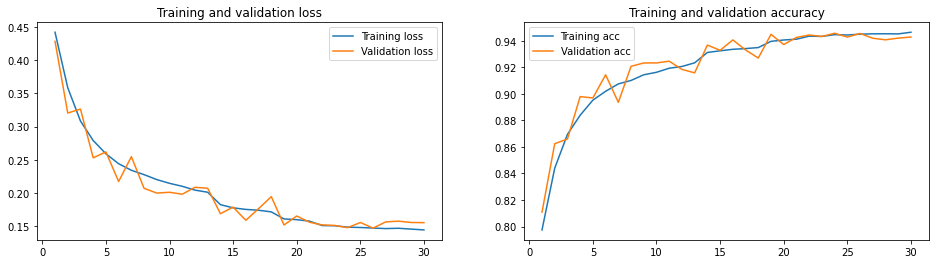

<Figure size 432x288 with 0 Axes>

In [52]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss,  label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.figure()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

### Make a prediction on the test set
We need these predictions to calculate the AUC score, print the Confusion Matrix and calculate the F1 score.

In [31]:
#Test-time Augmentation

df_size = num_test_samples
predictions1 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    
predictions2 = model.predict_generator(test_gen, steps=df_size, verbose=1)

predictions3 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    
predictions4 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    
predictions5 = model.predict_generator(test_gen, steps=df_size, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
21783/21783 [==============================] - 68s 3ms/step


In [32]:
predictions = predictions1 + predictions2 + predictions3 + predictions4 + predictions5
predictions

array([[4.9971800e+00, 2.8202697e-03],
       [3.6762328e+00, 1.3237672e+00],
       [4.9987178e+00, 1.2824856e-03],
       ...,
       [3.7248966e-01, 4.6275105e+00],
       [6.8933606e-02, 4.9310660e+00],
       [7.4815452e-02, 4.9251847e+00]], dtype=float32)

In [33]:
np.putmask(predictions, predictions < 3, 0)
np.putmask(predictions, predictions >= 3, 1)

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

y_true = test_gen.classes
y_pred = df_preds['has_tumor_tissue']

print("F1 Score: ")
print(f1_score(y_true, y_pred))
print("AUC Score: ")
print(roc_auc_score(y_true, y_pred))
    
test_labels = test_gen.classes
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
    
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1score=(2*precision*recall)/(recall+precision)
accuracy = (tp + tn)/(tp + fp + tn + fn)
    
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1 Score: " + str(f1score))
print("Accuracy: " + str(accuracy))
    

F1 Score: 
0.9371891266628108
AUC Score: 
0.9450590916627838
Precision: 0.9568914609661037
Recall: 0.918281763572481
F1 Score: 0.9371891266628108
Accuracy: 0.9501446081806914


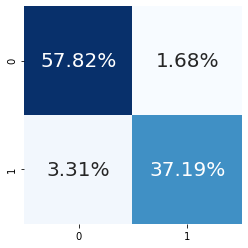

In [37]:
#Confusion Matrix
sns.heatmap(cm/np.sum(cm), fmt='.2%' , annot=True, cmap='Blues', square=True, cbar = False,
            annot_kws={'size':25})